In [ ]:
# default_exp core

## Todos

- [ ] Decompose this notebook into multiple notebooks 
    - [ ] one for data preparation ( training, validation and test )
    - [ ] one for fgcnn
    - [ ] one for ipnn
    - [ ] one for experimenting with training dl models heuristics, e.g. observer batch loss graph etc.
- [ ] Add docs about the paper and what are the key ideas.
- [ ] Highlight input parameter calculation in the model notebooks.
- [ ] Add section for the dataset used for validating model results.
- [ ] Section for further ideas and current implementation.

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from   pathlib import Path
from   fastai.tabular.all import *
import pandas as pd
from   datetime import datetime

In [ ]:
DATA_DIR = Path('/home/jovyan/data/')

In [ ]:
%%time
date_parser = lambda date: datetime.strptime(date, '%y%m%d%H')

df      = pd.read_csv(DATA_DIR / 'train', nrows=14000000, #parse_dates=['hour'], date_parser=date_parser
                     )
# test set is any row on `141023`
df_test = df.loc[df.hour.astype('str').str.slice(0, 6) == '141023']

# train set is any row 
df      = df.loc[df.hour < 14102300]

print(f'train shape: {df.shape}, test shape: {df_test.shape}')

#df_test = pd.read_csv(DATA_DIR / 'test' , parse_dates=['hour'], date_parser=date_parser)

# decompose hour into weekday and hour
# df = df.assign(weekday=df.hour.dt.weekday)
# df = df.assign(click_hour=df.hour.dt.hour)

# df_test = df_test.assign(weekday=df_test.hour.dt.weekday)
# df_test = df_test.assign(click_hour=df_test.hour.dt.hour)

train shape: (9460121, 24), test shape: (3870752, 24)
CPU times: user 39.4 s, sys: 2.12 s, total: 41.5 s
Wall time: 41.5 s


In [ ]:
#decompose hour into weekday and hour
df      = df.assign(click_hour=df.hour.astype('str').str.slice(6))
df_test = df_test.assign(click_hour=df_test.hour.astype('str').str.slice(6))

In [ ]:
def HourSplitter(hour='141022', seed=None):
    "Create function that splits `items` between train/val with based on date."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        indices  = o.index.values
        valid    = np.where(o.hour.astype(str).str.slice(0, 6) == hour)[0]
        train    = list(set(indices) - set(valid))
        
        return indices[train],indices[valid]
    return _inner

In [ ]:
df.click.value_counts(normalize=True)

0    0.83541
1    0.16459
Name: click, dtype: float64

In [ ]:
%%time

cat_names  = ['C1', 'banner_pos', 'site_id', 'site_domain',
              'site_category', 'app_id', 'app_domain', 'app_category',
              'device_id', 'device_ip', 'device_model', 'device_type',
              'click_hour', 'device_conn_type', 'C14', 'C15',
              'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
             ]

cont_names = []
procs      = [Categorify, FillMissing]

splits = HourSplitter(seed=41)(df)
# splits = RandomSplitter(seed=41)(df)
dls    = TabularDataLoaders.from_df(df, 
                                 path='.', 
                                 procs=procs, 
                                 cat_names=cat_names, 
                                 cont_names=cont_names, 
                                 y_names="click", 
                                 splits=splits, 
                                 bs=2048
                                )

CPU times: user 40.6 s, sys: 3.12 s, total: 43.8 s
Wall time: 43.5 s


In [ ]:
dls.show()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,click_hour,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,click
8197153,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,332dc66b,76dc4769,1,15,0,21882,320,50,2526,0,35,-1,221,0
1815298,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,a99f214a,23cfd878,a8964a12,1,08,0,6560,320,50,571,2,39,100048,32,1
6789492,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,3e2c01db,e47f989b,1,11,0,21767,320,50,2506,0,35,100020,157,0
7063646,1005,0,85f751fd,c4e18dd6,50e219e0,66f5e02e,6f7ca2ba,0f2161f8,c28f0035,c5d4327c,9e3836ff,1,11,0,21772,300,50,2507,0,35,-1,157,0
809392,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d01c28e4,4ceb2e0b,1,04,0,17914,320,50,2043,2,39,100084,32,0
8312094,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1812cdb7,23885c9e,1,16,0,15704,320,50,1722,0,35,-1,79,0
3817921,1005,0,85f751fd,c4e18dd6,50e219e0,8bbb7062,ef1fc174,0f2161f8,5c01cfbc,2b0f4c31,fce66524,1,20,0,21189,320,50,2424,1,161,-1,71,0
4375335,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,0cdc2afe,76dc4769,1,02,0,19950,320,50,1800,3,167,100075,23,0
3324163,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,8ded1f7a,ee459291,ad01d971,47a322d1,1,17,0,17016,320,50,1873,3,39,-1,23,0
8414628,1005,0,85f751fd,c4e18dd6,50e219e0,7358e05e,b9528b13,cef3e649,7961236b,a1ce9c97,684581ce,1,17,0,1037,320,50,178,3,1327,-1,15,1


## Embeddings

In [ ]:
def _fixed_emb_sz(classes, n, k):
    "Pick a fixed embedding size for `n` based on `k`."
    n_cat = len(classes[n])
    sz    = k  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, k):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_fixed_emb_sz(to.classes, n, k) for n in to.cat_names]

## Avazu Model ( FGCNN v2 )

In [ ]:
class ConvPoolRecombine(Module):
    """
    input : ( N, C_in, H, W ), where w represents `k` ( emebdding size )
    output: ( N, new_i, H / 2, W), where `2` represents max pool kernel size which is fixed as `2` for now.
    """
    
    def __init__(self, ch_in, ch_out, recomb_ch_out, out_wh, h, hp):
        store_attr()
        
        self.conv = nn.Conv2d(in_channels=ch_in,
                              out_channels=ch_out,
                              kernel_size=(h, 1),
                              padding='same',
                              stride=(1, 1)
                             )
        
        self.tanh   = nn.Tanh()
        self.pool   = nn.MaxPool2d(kernel_size=(hp, 1))
        
        self.recomb = nn.Linear(out_wh*ch_out, out_wh*recomb_ch_out)
    
    def forward(self, x):
        batch_size = x.shape[0]
        embed_size = x.shape[3]
        
        # output shape: (N, C_out, H, W)
        c = self.conv(x)
        c = self.tanh(c)
        
        # output shape: (N, C_out, H / hp, W), where hp = `2`
        p = self.pool(c)
        
        # output shape: (N, H / hp, W, C_out)
        f = p.permute([0, 2, 3, 1]).contiguous()
        
        # flattening
        # shape: (N, H/2*W*C_out)
        f = f.view(batch_size, -1)
        
        # recombining
        # shape: (N, H/2, W, C_new)
        r = self.recomb(f).view(batch_size, -1, embed_size, self.recomb_ch_out)
        
        # shape: (N, c_new*H/hp, W)
        out_r = r.permute([0, 3, 1, 2]).contiguous().view(batch_size, -1, embed_size)
        
        return p, out_r
    
class FGCNN_v2(Module):
    def __init__(self, emb_szs, conv_kernels, kernels, dense_layers, h, hp):
        """
        emb_szs     : list of tuples representing embedding size e.g. [(4, k), (6, k)]
        conv_kernels: list of convolutional kernels
        kernels     : kernels to be used
        h           : convolutional filter size
        hp          : pooling kernel size
        """
        
        self.k        = emb_szs[0][1]
        self.n_fields = len(emb_szs) 
        self.embeds   = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.n_emb    = sum(e.embedding_dim for e in self.embeds)
        
        self.conv_layers = nn.ModuleList([ConvPoolRecombine(ch_in=1 if i == 0 else conv_kernels[i-1], 
                                                            ch_out=conv_kernels[i], 
                                                            recomb_ch_out=kernels[i],
                                                            out_wh=int(self.n_fields / (2 ** (i + 1))) * self.k,
                                                            h=h, 
                                                            hp=hp
                                                           ) for i in range(len(conv_kernels))
                                         ])
        
        N = np.sum([int(self.n_fields / (hp ** (i + 1))) for i in range(len(conv_kernels))]) * kernels[0]
        
        self.lin_in = self.n_fields * self.k + int((N + self.n_fields) * (N + self.n_fields - 1) / 2)
        
        # MLP classifier
        self.act = nn.ReLU()
        self.mlp = nn.ModuleList([LinBnDrop(n_in=self.lin_in if i == 0  else dense_layers[i-1], 
                                            n_out=dense_layers[i],
                                            act=self.act
                                            ) 
                                          for i in range(len(dense_layers))
                                 ])
         
        self.final_linear = nn.Linear(in_features=dense_layers[-1], out_features=1, bias=False)
        self.sigmoid      = nn.Sigmoid()
        
        store_attr()
    
    def forward(self, x, x_cont):
        bs = x.shape[0]
        
        if self.n_emb != 0:
            x = [e(x[:,i]).unsqueeze(dim=1) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            
        embed = x.clone()
        
        input_x = x.view(bs, 1, self.n_fields, self.k)
        
        p     = input_x
        out_r = []
        for i in range(len(self.conv_layers)):
            p, r = self.conv_layers[i](p)
            out_r.append(r)
        
        # shape: (bs, C_new * ( H / 2 ^ i), embed_size)
        new_features = torch.cat(out_r, dim=1)
        
        # combine features
        aug_emb = torch.cat([embed, new_features], dim=1)
        
        # inner product factorization machine using augmented embedding matrix
        fm = []
        
        for i in range(aug_emb.shape[1]):
            for j in range(i+1, aug_emb.shape[1]):
                fm.append(torch.sum(torch.mm(aug_emb[:,i,:],
                                             aug_emb[:,j,:].T), dim=1
                                   ).unsqueeze(dim=1))

        fm  = torch.cat(fm, dim=1)
        
        # flatten
        out = torch.cat([fm, embed.view(bs, -1)], dim=1)
        
        for i in range(len(self.mlp)):
            out = self.mlp[i](out)
            
        out = self.final_linear(out)
        out = self.sigmoid(out)
        
        return out

## Avazu Model ( FGCNN v1 )

In [ ]:
def _make_conv(ni, mc, h, hp):
    return nn.Sequential(nn.Conv2d(in_channels=ni, 
                                   out_channels=mc, 
                                   kernel_size=(h, 1), 
                                   padding='same', 
                                   stride=(1, 1)
                                  ),
                         nn.Tanh(),
                         nn.MaxPool2d(kernel_size=(hp, 1))
                        )

def _make_recombination(nf, hp, k, mc, mr):
    fan_in = (nf // hp ) if (nf // hp) > 0 else 1
    return nn.Linear(in_features=fan_in*k*mc,
                     out_features=fan_in*k*mr
                    )


class IPNN(Module):
    def __init__(self, dense_layers):
        self.flatten     = nn.Flatten()
        self.act         = nn.ReLU()
        
        self.lin_bn_drop = nn.ModuleList([LinBnDrop(n_in=dense_layers[i], 
                                                    n_out=dense_layers[i+1],
                                                    act=self.act
                                                   ) 
                                          for i in range(len(dense_layers) - 1)
                                         ])
        
        self.final_linear = nn.Linear(in_features=dense_layers[-1], out_features=1, bias=False)
        self.sigmoid      = nn.Sigmoid()
    
    def forward(self, aug_emb):
        fm = []
        
        for i in range(aug_emb.shape[1]):
            for j in range(i+1, aug_emb.shape[1]):
                fm.append(torch.sum(torch.mm(aug_emb[:,i,:],
                                             aug_emb[:,j,:].T), dim=1
                                   ).unsqueeze(dim=1))

        fm  = torch.cat(fm, dim=1)
        rfm = torch.cat((fm, self.flatten(aug_emb)), dim=1)
        
        dense_out = rfm
        for i in range(len(self.lin_bn_drop)):
            dense_out = self.lin_bn_drop[i](dense_out)
        
        final_res = self.final_linear(dense_out)
        out       = self.sigmoid(final_res)
        
        return out
        
class FGCNN(Module):
    def __init__(self, emb_szs, conv_kernels, kernels, h, hp):
        """
        emb_szs     : list of tuples representing embedding size e.g. [(4, k), (6, k)]
        conv_kernels: list of convolutional kernels
        kernels     : kernels to be used
        h           : convolutional filter size
        hp          : pooling kernel size
        """
        
        self.k      = emb_szs[0][1]
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.n_emb  = sum(e.embedding_dim for e in self.embeds)
        
        self.conv_layers = nn.ModuleList([_make_conv(ni=1, mc=conv_kernels[0], h=h, hp=hp)]  +\
                                         [_make_conv(conv_kernels[i-1], conv_kernels[i], h=h, hp=hp) \
                                         for i in range(1, len(conv_kernels))]
                                        )
        
        nf          = len(self.embeds)
        self.linear = nn.ModuleList()
        
        for i in range(len(conv_kernels)):
            self.linear.append(_make_recombination(nf // (hp ** i), hp, self.k, conv_kernels[i], mr=kernels[i]))
            
        
        self.flatten = nn.Flatten()
            
        store_attr()
        
        
    def forward(self, x):
        bs = x.shape[0]
        
        if self.n_emb != 0:
            x = [e(x[:,i]).unsqueeze(dim=1) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
        
        # embed is embedding matrix that would be used in deep
        # classifier.
        embed = x.clone()
        
        # x is embedding matrix used for feature generation
        x   = x.unsqueeze(dim=1) # adding a single channel for convolution
        out = x
        recombined = []
        
        for i in range(len(self.conv_layers)):
            out = self.conv_layers[i](out)
            
            flat = self.flatten(out)
            flat = self.linear[i](flat)
            flat = flat.reshape(bs, -1, self.k)
            
            recombined.append(flat)
            
        recombined = torch.cat(recombined, dim=1)
        recombined = torch.cat((recombined, embed), dim=1)

        return recombined        

In [ ]:
class AvazuModel(Module):
    def __init__(self, k, emb_szs, conv_kernels=[6, 8], kernels=[3, 3], h=7, hp=2, dense_layers=[]):
        # store all attributes
        store_attr()
        
        self.fgcnn   = FGCNN(emb_szs, conv_kernels, kernels, h, hp)
        self.n_fgcnn = self.get_num_feats(emb_szs, kernels)
        
        tot_f = len(emb_szs) + self.n_fgcnn
        tot_f = (tot_f * k) + (((tot_f * (tot_f - 1)) / 2))
        
        dense_layers = [int(tot_f)] + dense_layers
        self.ipnn    = IPNN(dense_layers)
        
        
        
    def forward(self, x_cat, x_cont):
        out = self.fgcnn(x_cat)
        out = self.ipnn(out)
        
        return out
    
    def get_num_feats(self, emb_szs, kernels):
        n_feats  = len(emb_szs)
        num_maps = n_feats 
        n = 0
        for i in range(len(kernels)):
            n += kernels[i] * (n_feats // (self.hp ** (i + 1)))
            
        return n

In [ ]:
cats, conts, y = dls.one_batch()

In [ ]:
emb_szs = get_emb_sz(dls.train_ds, k=40)

m = FGCNN_v2(emb_szs=emb_szs, 
             conv_kernels=[6, 8, 10, 12], 
             kernels=[2, 2, 2, 2],
             dense_layers=[256, 128, 64],
             h=7,
             hp=2
            )

torch.Size([2048, 1])


### Avazu Model using FGCNN v1

In [ ]:
emb_szs = get_emb_sz(dls.train_ds, k=40)
m       = AvazuModel(k=40, 
                     emb_szs=emb_szs, 
                     conv_kernels=[14, 16, 18, 20], 
                     kernels=[3, 3, 3, 3],
                     dense_layers=[256, 128, 64]
                    )

### FGCNN v2

In [ ]:
emb_szs = get_emb_sz(dls.train_ds, k=40)

m = FGCNN_v2(emb_szs=emb_szs, 
             conv_kernels=[14, 16, 18, 20], 
             kernels=[3, 3, 3, 3],
             dense_layers=[4096, 2048, 1024, 512],
             h=7,
             hp=2
            )

In [ ]:
learn = TabularLearner(dls, m, loss_func=BCELossFlat(), opt_func=ranger)

/home/jovyan/my-conda-envs/dev/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.00019054606673307717)

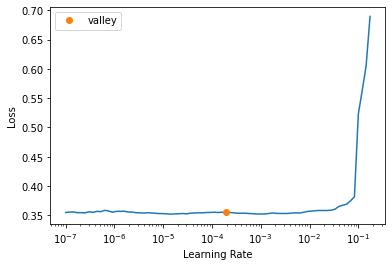

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(1, 2e-4, cbs=EarlyStoppingCallback())

epoch,train_loss,valid_loss,time


In [ ]:
learn.validate()

In [ ]:
# save model
learn.save(file=DATA_DIR / 'models' / 'fgcnn_v2_single_epoch_es_but_last_day.pkl')

In [ ]:
dl    = learn.dls.test_dl(df_test)
preds = learn.get_preds(dl=dl)

In [ ]:
tst = BCELossFlat()
tst(preds[0], torch.tensor(df_test['click'].values).float())

TensorBase(0.4240)

In [ ]:
sub = pd.read_csv(DATA_DIR / 'sampleSubmission')
sub.loc[:, 'click'] = preds[0].squeeze(dim=1).cpu().numpy()

sub.to_csv(DATA_DIR / 'submissions' / 'fgcnn_v2_single_epoch_es_but_last_day.csv', index=False)